# CAM

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
# for Tensorboard
import datetime
import os

#logdir="/content/drive/MyDrive/Colab/TB/CAM_test/" + datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)


In [3]:
# 데이터 다운로드
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [4]:
num_classes = ds_info.features["label"].num_classes    # 카테고리 개수

# Pre-trained model 생성
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,     # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',      # GAP를 적용  
)    

# 분류기 덧붙이기
x = base_model.output    # base_model의 출력을 x라고 하자
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
    # x를 카테고리 수에 맞는 FC layer에 통과시켜서 분류한 결과물
cam_model = keras.Model(inputs=base_model.input, outputs=preds)
    # base_model을 집어넣어서 preds가 나오는 모델


# 모델 컴파일
tf.random.set_seed(2021)  # 매번 동일한 결과가 나올 수 있도록 시드 고정

cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

94773248/94765736 [==============================] - 0s 0us/step


In [5]:
# 이미지 정규화 함수
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

# 데이터셋을 정규화후 배치처리하는 함수
BATCHSIZE = 16

def apply_normalize_on_dataset(ds, is_test=False, batch_size=BATCHSIZE):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

# 데이터셋에 전처리와 배치처리를 적용
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test, is_test=True) # is_test 넣어줌

In [6]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCHSIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCHSIZE),
    epochs=20,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[tensorboard_callback]
)

Epoch 1/20
750/750 [==============================] - 341s 419ms/step - loss: 3.1896 - accuracy: 0.2784 - val_loss: 3.0145 - val_accuracy: 0.2719
Epoch 2/20
750/750 [==============================] - 318s 424ms/step - loss: 0.9427 - accuracy: 0.7439 - val_loss: 1.0736 - val_accuracy: 0.6820
Epoch 3/20
750/750 [==============================] - 320s 427ms/step - loss: 0.3178 - accuracy: 0.9248 - val_loss: 0.9445 - val_accuracy: 0.7252
Epoch 4/20
750/750 [==============================] - 321s 428ms/step - loss: 0.0809 - accuracy: 0.9922 - val_loss: 0.9229 - val_accuracy: 0.7316
Epoch 5/20
750/750 [==============================] - 321s 429ms/step - loss: 0.0315 - accuracy: 0.9991 - val_loss: 0.9183 - val_accuracy: 0.7374
Epoch 6/20
750/750 [==============================] - 322s 429ms/step - loss: 0.0190 - accuracy: 0.9998 - val_loss: 0.9360 - val_accuracy: 0.7350
Epoch 7/20
750/750 [==============================] - 321s 428ms/step - loss: 0.0294 - accuracy: 0.9988 - val_loss: 0.9668 -

In [7]:
# 학습한 가중치 저장
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
#cam_model_path = '/content/drive/MyDrive/Colab/aiffel/class_activation_map/cam_model.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

저장 완료!


pip install -U tensorboard

!tensorboard dev upload --logdir logs --name "Model" --description "CAM"

In [9]:
# 데이터셋에서 한장씩 뽑아내는 함수
 
def get_one(ds): 
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

In [11]:
# CAM을 생성하는 함수
def generate_cam(model, item):
    item = copy.deepcopy(item)      # 주어진 이미지를 카피해서 저장
    width = item['image'].shape[1]  # 이미지의 사이즈 변수에 저장
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item) # 이미지 정규화
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()  # 넘파이 배열로 전환
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

In [12]:
# 원본이미지와 CAM 을 합치는 함수
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

67


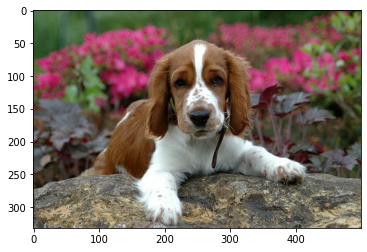

In [13]:
# CAM을 확인하기 위해서 한장 고르기
item = get_one(ds_test)    # 학습에 사용하지 않은 테스트셋에서 한 장 뽑음
print(item['label'])       # 라벨 출력 (라벨이 견종이 아니라 숫자로 되어있다)
plt.imshow(item['image'])
plt.show()

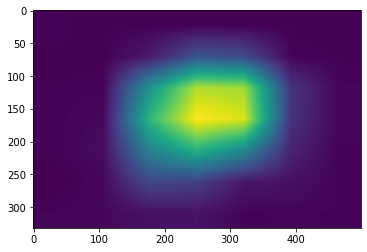

In [14]:
# CAM 확인
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

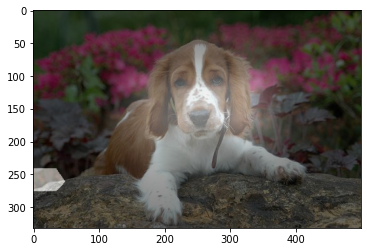

In [15]:
# 원본 이미지와 CAM 블랜딩

origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

# Grad-CAM

In [16]:
# Grag-CAM 생성하는 함수
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

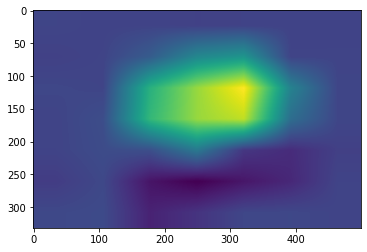

In [17]:
# 레이어의 CAM 이미지 확인
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

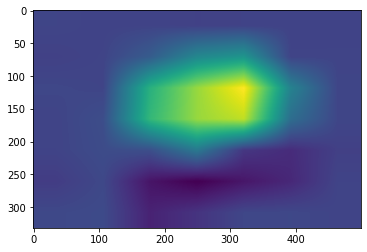

In [18]:
am_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

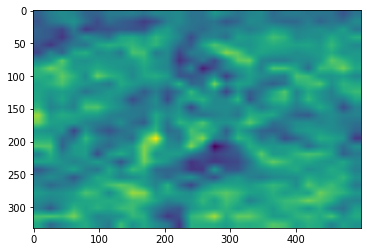

In [19]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

# Detection

In [20]:
# Bbox 얻는 함수 만들기
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect           # 매트릭스 결과가 반환

In [24]:
rect = get_bbox(cam_image)
rect

array([[111,  33],
       [441,  33],
       [441, 305],
       [111, 305]])

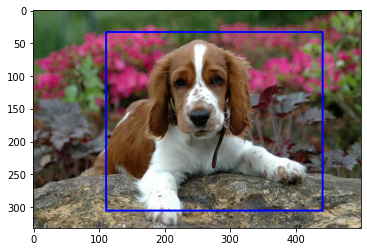

In [21]:
# 이미지 위에 Bbox 그리기
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

# IoU 계산

In [22]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]),  #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1])   #bounding box의 x_max
    ]
    return bbox      # 좌표를 리스트로 반환

In [23]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.09939759036144578, 0.222, 0.9186746987951807, 0.882]

In [25]:
# 실제 ground truth bbox 확안
item['objects']['bbox']

array([[0.13554217, 0.146     , 0.9879518 , 0.826     ]], dtype=float32)

In [26]:
# IoU로 유사도 확인
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

get_iou(pred_bbox, item['objects']['bbox'][0])

0.7306904519066656